In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base_dir = '/kaggle/input/small-dataset-glrv/small_dataset_glrv2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

**Data preprocessing**

In [4]:
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle= True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 14543 files belonging to 10 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                            shuffle= True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 3636 files belonging to 10 classes.


In [6]:
class_names = train_dataset.class_names

In [7]:
class_names

['113209',
 '126637',
 '138982',
 '139894',
 '149980',
 '177870',
 '1924',
 '194914',
 '20409',
 '83144']

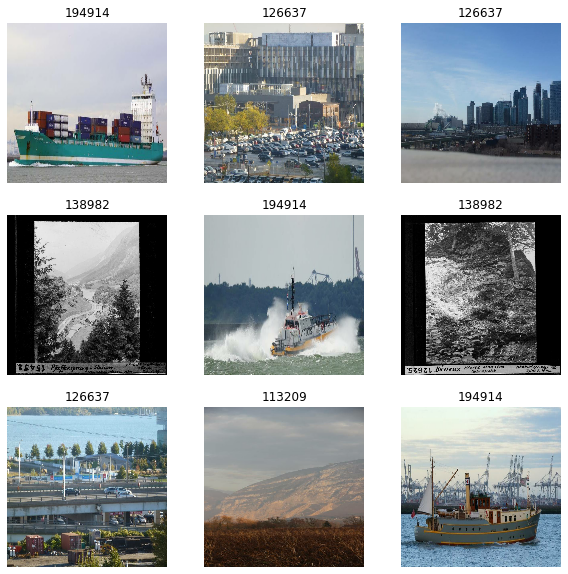

In [8]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('Off')

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 92
Number of test batches: 22


In [11]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

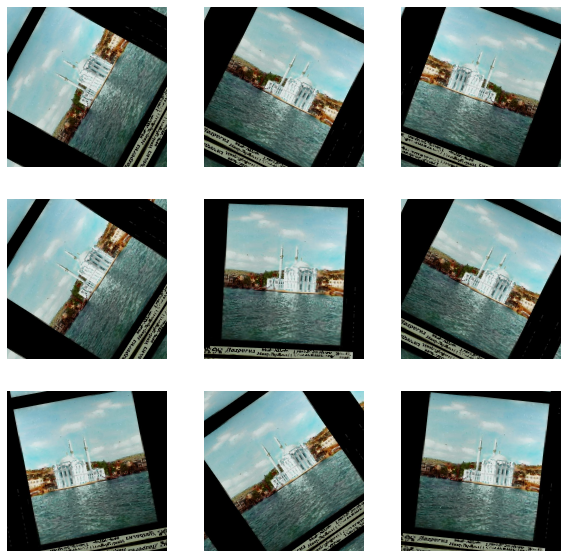

In [13]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('Off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1/127.5, offset = -1)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
image_batch,label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [19]:
base_model.trainable = False

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [22]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr= base_learning_rate),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics=['accuracy'])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

92/92 [==============================] - 12s 126ms/step - loss: 2.3157 - accuracy: 0.2268


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.32
initial accuracy: 0.23


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
455/455 [==============================] - 74s 163ms/step - loss: 1.2135 - accuracy: 0.6095 - val_loss: 0.8885 - val_accuracy: 0.7565
Epoch 2/10
455/455 [==============================] - 51s 113ms/step - loss: 0.6571 - accuracy: 0.7864 - val_loss: 0.6209 - val_accuracy: 0.8312
Epoch 3/10
455/455 [==============================] - 52s 113ms/step - loss: 0.5131 - accuracy: 0.8351 - val_loss: 0.5193 - val_accuracy: 0.8568
Epoch 4/10
455/455 [==============================] - 51s 113ms/step - loss: 0.4515 - accuracy: 0.8542 - val_loss: 0.4635 - val_accuracy: 0.8731
Epoch 5/10
455/455 [==============================] - 51s 113ms/step - loss: 0.4033 - accuracy: 0.8691 - val_loss: 0.4282 - val_accuracy: 0.8840
Epoch 6/10
455/455 [==============================] - 52s 114ms/step - loss: 0.3711 - accuracy: 0.8820 - val_loss: 0.3926 - val_accuracy: 0.8932
Epoch 7/10
455/455 [==============================] - 51s 112ms/step - loss: 0.3529 - accuracy: 0.8849 - val_loss: 0.3763 - val_ac

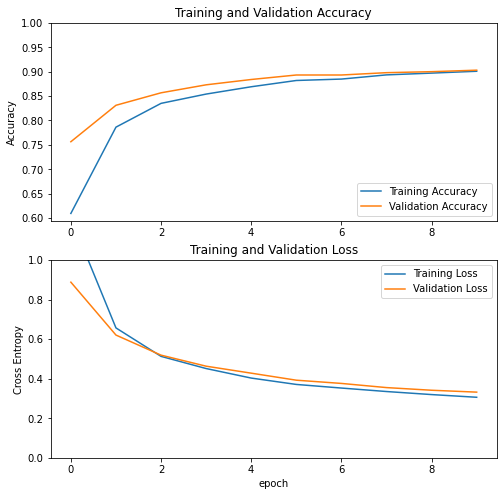

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


Number of layers in the base model:  155


In [32]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [34]:
len(model.trainable_variables)


58

In [35]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/kaggle/working/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=[cp_callback],
                         validation_data=validation_dataset)


Epoch 10/60
455/455 [==============================] - 54s 119ms/step - loss: 0.2804 - accuracy: 0.9074 - val_loss: 0.2826 - val_accuracy: 0.9120
Epoch 11/60
455/455 [==============================] - 53s 116ms/step - loss: 0.2313 - accuracy: 0.9260 - val_loss: 0.2328 - val_accuracy: 0.9277
Epoch 12/60
455/455 [==============================] - 53s 117ms/step - loss: 0.1915 - accuracy: 0.9361 - val_loss: 0.2541 - val_accuracy: 0.9192
Epoch 13/60
455/455 [==============================] - 53s 117ms/step - loss: 0.1747 - accuracy: 0.9430 - val_loss: 0.1980 - val_accuracy: 0.9366
Epoch 14/60
453/455 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9498
Epoch 00014: saving model to /kaggle/working/cp-0014.ckpt
455/455 [==============================] - 53s 117ms/step - loss: 0.1546 - accuracy: 0.9498 - val_loss: 0.1870 - val_accuracy: 0.9430
Epoch 15/60
455/455 [==============================] - 54s 118ms/step - loss: 0.1434 - accuracy: 0.9519 - val_loss: 0.1707 - va

455/455 [==============================] - 55s 120ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.1184 - val_accuracy: 0.9720
Epoch 58/60
455/455 [==============================] - 54s 119ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.1158 - val_accuracy: 0.9727
Epoch 59/60
453/455 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9966
Epoch 00059: saving model to /kaggle/working/cp-0059.ckpt
455/455 [==============================] - 53s 117ms/step - loss: 0.0109 - accuracy: 0.9966 - val_loss: 0.1186 - val_accuracy: 0.9734
Epoch 60/60
455/455 [==============================] - 54s 118ms/step - loss: 0.0107 - accuracy: 0.9964 - val_loss: 0.1163 - val_accuracy: 0.9744


In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

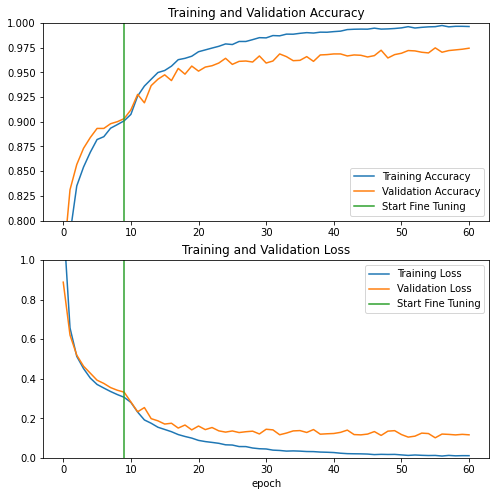

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 2s 101ms/step - loss: 0.1289 - accuracy: 0.9702
Test accuracy : 0.9701704382896423


Predictions:
 [9 2 2 8 4 2 1 3 8 0 1 2 2 2 7 8 6 2 9 3 2 5 8 5 2 4 2 2 2 6 2 2]
Labels:
 [9 2 2 8 4 2 1 6 8 0 1 2 2 2 7 8 6 2 9 3 2 5 8 5 2 4 2 2 2 6 2 2]


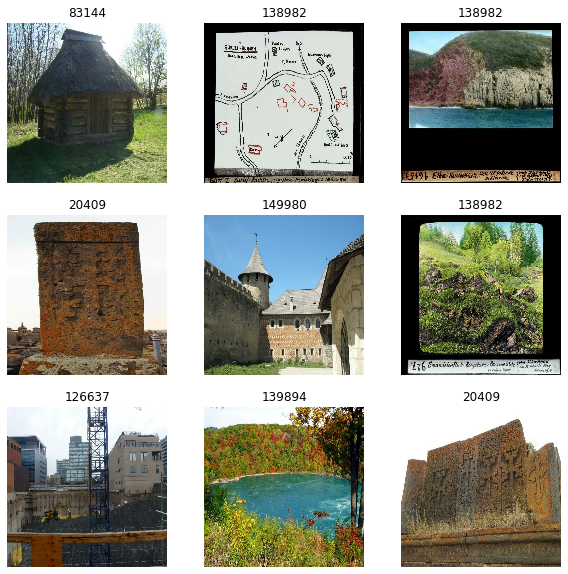

In [39]:

image_batch,label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.nn.softmax(predictions)
print('Predictions:\n', np.argmax(predictions.numpy(),axis=1))
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

In [40]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [41]:
latest

'/kaggle/working/cp-0059.ckpt'

In [42]:
model.save('mobilenetv2.h5')

In [43]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [45]:
from tensorflow.keras.models import Model

In [48]:
intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer("global_average_pooling2d").output)

In [49]:
import numpy as np

In [55]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet50

def get_vec(image_path,intermediate_layer_model):
    """ Gets a vector embedding from an image.
    :param image_path: path to image on filesystem
    :returns: numpy ndarray
    """

    img = image.load_img(image_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    intermediate_output = intermediate_layer_model.predict(x)

    return intermediate_output[0]

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
import glob
from tqdm.autonotebook import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [57]:
l113209_1_vec = get_vec('/kaggle/input/small-dataset-glrv/small_dataset_glrv2/validation/113209/03af458772602abb.jpg',intermediate_layer_model)
l113209_2_vec = get_vec('/kaggle/input/small-dataset-glrv/small_dataset_glrv2/validation/113209/05b418379cee5736.jpg',intermediate_layer_model)
l126637_1_vec = get_vec('/kaggle/input/small-dataset-glrv/small_dataset_glrv2/validation/126637/023489b87edcd1b0.jpg',intermediate_layer_model)
l126637_2_vec = get_vec('/kaggle/input/small-dataset-glrv/small_dataset_glrv2/validation/126637/02d7841f33e7297b.jpg',intermediate_layer_model)

X = np.stack([l113209_1_vec, l113209_2_vec, l126637_1_vec, l126637_2_vec])
Y = X
similarity_matrix = cosine_similarity(X, Y)

print(similarity_matrix)

[[0.99999976 0.48043764 0.36978585 0.51643914]
 [0.48043764 0.9999995  0.54173636 0.5451869 ]
 [0.36978585 0.54173636 1.0000001  0.56385326]
 [0.51643914 0.5451869  0.56385326 1.        ]]


In [59]:
image_paths = glob.glob('/kaggle/input/small-dataset-glrv/small_dataset_glrv2/validation/*/*.jpg')

In [63]:
len(image_paths)

3636

In [66]:
image_vectors = {}
for image_path in tqdm(image_paths):
    vector = get_vec(image_path,intermediate_layer_model)
    image_vectors[image_path] = vector

In [79]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [68]:
X = np.stack(list(image_vectors.values()))

In [74]:
pca_100 = PCA(n_components=100)
pca_result_100 = pca_100.fit_transform(X)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_100.explained_variance_ratio_)))
print(np.shape(pca_result_100))

    
tsne = TSNE(n_components=2, verbose=1, n_iter=3000)
tsne_result = tsne.fit_transform(pca_result_100)

Cumulative explained variation for 50 principal components: 0.722125768661499
(3636, 100)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3636 samples in 0.088s...
[t-SNE] Computed neighbors for 3636 samples in 2.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3636
[t-SNE] Computed conditional probabilities for sample 2000 / 3636
[t-SNE] Computed conditional probabilities for sample 3000 / 3636
[t-SNE] Computed conditional probabilities for sample 3636 / 3636
[t-SNE] Mean sigma: 7.504260
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.155815
[t-SNE] KL divergence after 3000 iterations: 1.479717


In [75]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

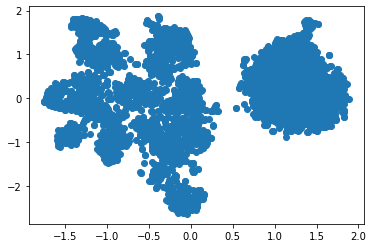

In [76]:
plt.scatter(tsne_result_scaled[:,0], tsne_result_scaled[:,1])

In [77]:
images = []
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (50,50))
    images.append(image)    

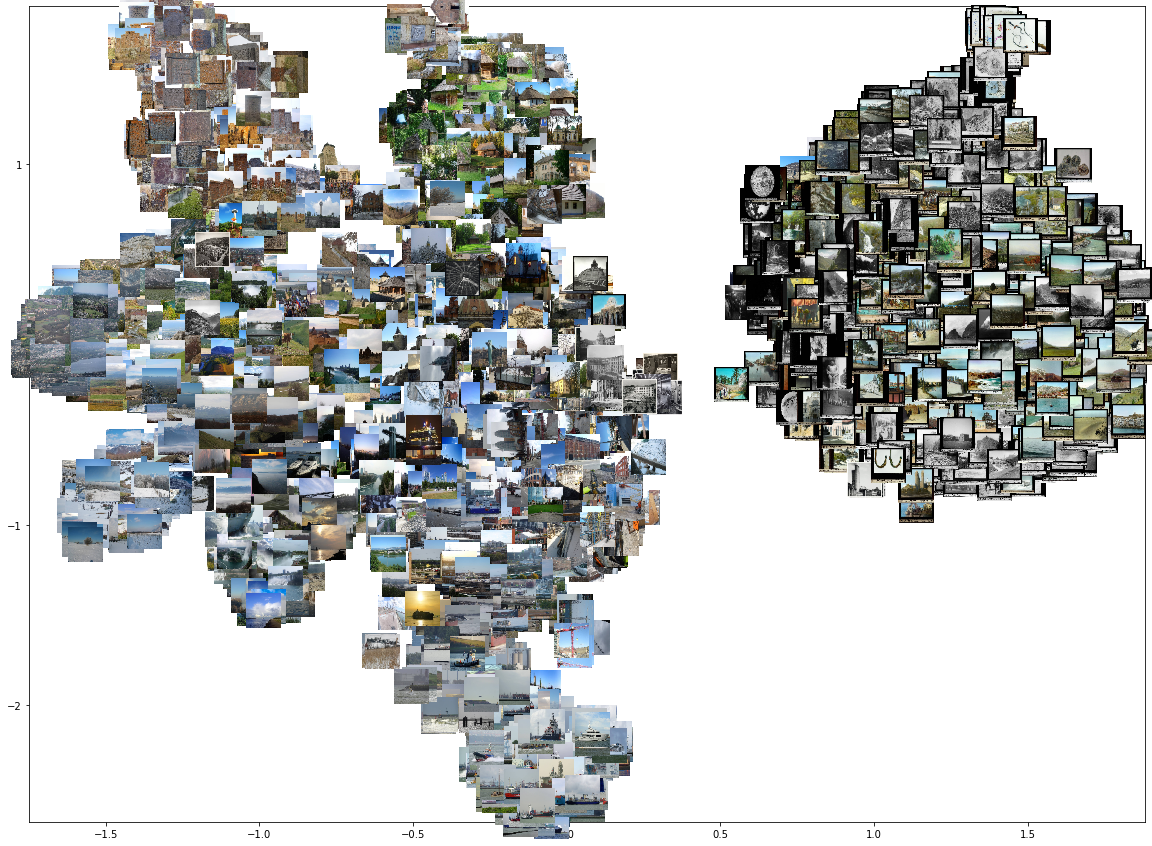

In [80]:
fig, ax = plt.subplots(figsize=(20,15))
artists = []

for xy, i in zip(tsne_result_scaled, images):
    x0, y0 = xy
    img = OffsetImage(i, zoom=.7)
    ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
ax.update_datalim(tsne_result_scaled)
ax.autoscale(enable=True, axis='both', tight=True)
plt.show()

In [82]:
intermediate_layer_model.save('intermediate_layer_model.h5')